# **8 超参数搜索**

## **8.1 超参数**

1 有哪些超参数呢？    
网络结构参数：
- 层数，层的宽度，激活函数 


训练参数：
- batch_size，学习率，学习率衰减方法

2 超参数有哪些搜索的策略？
- 网格搜索
- 随机搜索
- 遗传算法搜索
- 启发式搜索
- 贝叶斯调优

> 基于遗传算法的超参数搜索模拟了自然界遗传规律，主要过程为
> - 初始化候选参数集合 -> 训练 -> 得到模型指标作为生存概率
> - 选择 -> 交叉 -> 变异 -> 产生下一代集合
> - 重新到第一步，直到满足规定条件

> 启发式搜索时当前的研究热点，是Auto-ML的核心领域
> 启发式搜索基于循环神经网络来生成参数，并适应强化学习进行反馈，使用模型训练生成参数

## **8.2 超参数搜索实践**

### **8.2.1 数据的加载与处理**

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os, sys, time, gc
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
from sklearn.model_selection import train_test_split
X_train_all, X_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, random_state=1)
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_val_scaled = std_scaler.transform(X_val)
X_test_scaled = std_scaler.transform(X_test)

### **8.2.2 基于手动实现的超参数搜索**

In [4]:
# 对learning rate搜索
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for lr in learning_rates:
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(128, activation='relu', input_shape=X_train.shape[1:]))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr))

    callbacks = [keras.callbacks.EarlyStopping(min_delta=1e-3, patience=5),]
    history = model.fit(X_train_scaled, y_train, batch_size=128, epochs=10, validation_data=(X_val_scaled, y_val), callbacks=callbacks)
    del model
    gc.collect()
    K.clear_session()
    histories.append(history)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 3s 220us/sample - loss: 4.2340 - val_loss: 3.5823
Epoch 2/10
11610/11610 [==============================] - 0s 27us/sample - loss: 3.2986 - val_loss: 2.7734
Epoch 3/10
11610/11610 [==============================] - 0s 27us/sample - loss: 2.5843 - val_loss: 2.1768
Epoch 4/10
11610/11610 [==============================] - 0s 27us/sample - loss: 2.0596 - val_loss: 1.7483
Epoch 5/10
11610/11610 [==============================] - 0s 28us/sample - loss: 1.6786 - val_loss: 1.4322
Epoch 6/10
11610/11610 [==============================] - 0s 30us/sample - loss: 1.4046 - val_loss: 1.2097
Epoch 7/10
11610/11610 [==============================] - 0s 29us/sample - loss: 1.2124 - val_loss: 1.0555
Epoch 8/10
11610/11610 [==============================] - 0s 27us/sample - loss: 1.0812 - val_loss: 0.9497
Epoch 9/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.9905 - val_

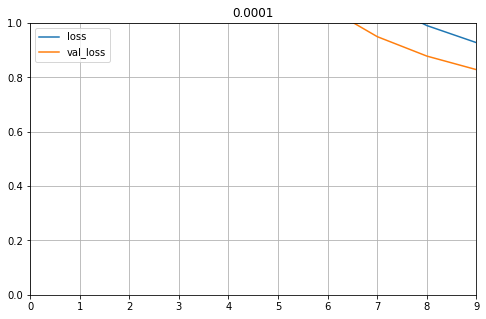

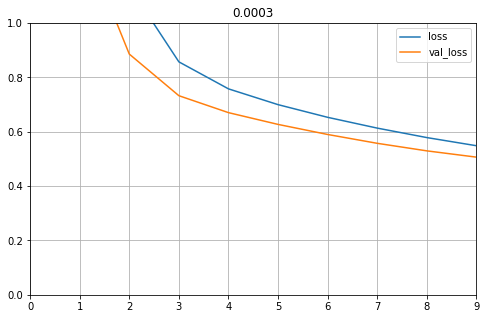

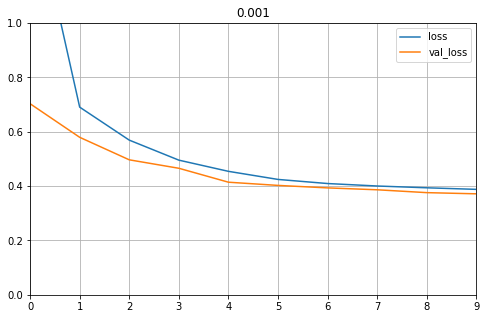

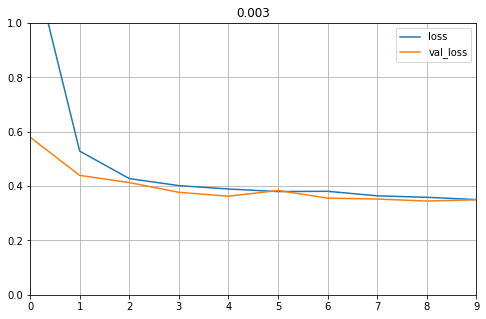

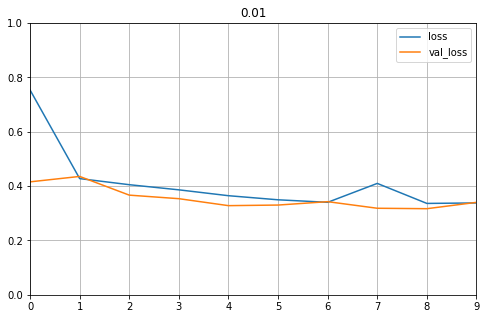

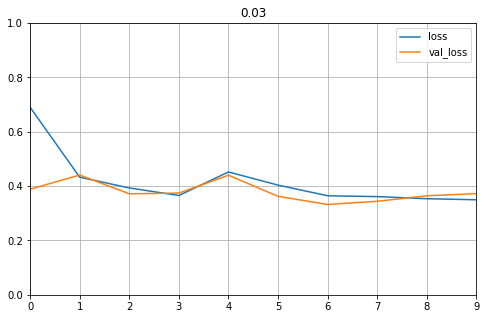

In [7]:
def plot_learning_curve(history, title):
    pd.DataFrame(history.history).plot(figsize=(8, 5)) 
    plt.grid(True)
    plt.title(title)
    plt.gca().set_ylim(0, 1)
    plt.show()
for history, rate in zip(histories, learning_rates):
    plot_learning_curve(history, rate)

### **8.2.3 使用sklearn封装keras模型**

RandomizedSearchCV
- 转换为sklearn的model [tf.keras.wrapper.scikit_learn.KerasRegressor/KerasClassifier](https://tensorflow.google.cn/versions/r2.0/api_docs/python/tf/keras/wrappers/scikit_learn?hl=zh-cn)
- 定义超参数集合
- 搜索超参数

In [10]:
# 首先需要定义一个返回模型的函数，参数为超参数
def build_model(hidden_layers = 1, layer_size = 30, learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', input_shape = X_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model
sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [11]:
# 调用方式和keras一样
history = sklearn_model.fit(X_train_scaled, y_train, batch_size=128, epochs=10, validation_data=(X_val_scaled, y_val), callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 52us/sample - loss: 1.5942 - val_loss: 0.7251
Epoch 2/10
11610/11610 [==============================] - 0s 28us/sample - loss: 0.6643 - val_loss: 0.5388
Epoch 3/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5121 - val_loss: 0.4574
Epoch 4/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4517 - val_loss: 0.4265
Epoch 5/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4280 - val_loss: 0.4046
Epoch 6/10
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4148 - val_loss: 0.3945
Epoch 7/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4040 - val_loss: 0.3902
Epoch 8/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3975 - val_loss: 0.3773
Epoch 9/10
11610/11610 [==============================] - 0s 27us/sample - loss: 0.3901 - val_l

### **8.2.4 sklearn超参数搜索**

In [14]:
from scipy.stats import reciprocal
# f(x) = 1 / (x *log(b / a))      x \in [a, b]
param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2)
}

from sklearn.model_selection import RandomizedSearchCV
random_search_cv = RandomizedSearchCV(sklearn_model, param_distribution, n_iter=10, n_jobs=1)

In [15]:
random_search_cv.fit(X_train_scaled, y_train, batch_size=128, epochs=10, validation_data=(X_val_scaled, y_val), callbacks=callbacks)

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 95us/sample - loss: 3.9171 - val_loss: 2.3119
Epoch 2/10
7740/7740 [==============================] - 0s 37us/sample - loss: 1.8219 - val_loss: 1.1387
Epoch 3/10
7740/7740 [==============================] - 0s 37us/sample - loss: 1.0833 - val_loss: 0.7976
Epoch 4/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.8308 - val_loss: 0.6492
Epoch 5/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6763 - val_loss: 0.5759
Epoch 6/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5930 - val_loss: 0.5147
Epoch 7/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5292 - val_loss: 0.4765
Epoch 8/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4822 - val_loss: 0.4464
Epoch 9/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4533 - val_loss: 0.4286
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 99us/sample - loss: 3.9213 - val_loss: 2.0804
Epoch 2/10
7740/7740 [==============================] - 0s 36us/sample - loss: 1.5069 - val_loss: 1.1055
Epoch 3/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.9707 - val_loss: 0.8132
Epoch 4/10
7740/7740 [==============================] - 0s 39us/sample - loss: 0.7502 - val_loss: 0.6764
Epoch 5/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.6398 - val_loss: 0.5771
Epoch 6/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5564 - val_loss: 0.5124
Epoch 7/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4956 - val_loss: 0.4681
Epoch 8/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4558 - val_loss: 0.4333
Epoch 9/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4227 - val_loss: 0.4042
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 98us/sample - loss: 3.5583 - val_loss: 1.9292
Epoch 2/10
7740/7740 [==============================] - 0s 36us/sample - loss: 1.3269 - val_loss: 1.1845
Epoch 3/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.9343 - val_loss: 0.8992
Epoch 4/10
7740/7740 [==============================] - 0s 39us/sample - loss: 0.7857 - val_loss: 0.7663
Epoch 5/10
7740/7740 [==============================] - 0s 43us/sample - loss: 0.6893 - val_loss: 0.6581
Epoch 6/10
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6083 - val_loss: 0.5810
Epoch 7/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5390 - val_loss: 0.5137
Epoch 8/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4870 - val_loss: 0.4706
Epoch 9/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4492 - val_loss: 0.4293
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 147us/sample - loss: 4.8523 - val_loss: 3.7375
Epoch 2/10
7740/7740 [==============================] - 0s 41us/sample - loss: 2.9414 - val_loss: 1.9643
Epoch 3/10
7740/7740 [==============================] - 0s 38us/sample - loss: 1.5996 - val_loss: 1.2272
Epoch 4/10
7740/7740 [==============================] - 0s 37us/sample - loss: 1.1151 - val_loss: 0.9297
Epoch 5/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.8922 - val_loss: 0.7643
Epoch 6/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.7712 - val_loss: 0.6758
Epoch 7/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6955 - val_loss: 0.6208
Epoch 8/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6463 - val_loss: 0.5836
Epoch 9/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6114 - val_loss: 0.5566
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 96us/sample - loss: 3.6319 - val_loss: 3.0012
Epoch 2/10
7740/7740 [==============================] - 0s 39us/sample - loss: 2.4639 - val_loss: 2.1779
Epoch 3/10
7740/7740 [==============================] - 0s 40us/sample - loss: 1.8263 - val_loss: 1.6520
Epoch 4/10
7740/7740 [==============================] - 0s 37us/sample - loss: 1.4878 - val_loss: 1.3156
Epoch 5/10
7740/7740 [==============================] - 0s 37us/sample - loss: 1.2425 - val_loss: 1.0915
Epoch 6/10
7740/7740 [==============================] - 0s 40us/sample - loss: 1.0654 - val_loss: 0.9140
Epoch 7/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.9203 - val_loss: 0.8050
Epoch 8/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.8322 - val_loss: 0.7332
Epoch 9/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.7617 - val_loss: 0.6693
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 95us/sample - loss: 5.4086 - val_loss: 4.6648
Epoch 2/10
7740/7740 [==============================] - 0s 39us/sample - loss: 4.1794 - val_loss: 3.3615
Epoch 3/10
7740/7740 [==============================] - 0s 42us/sample - loss: 2.8132 - val_loss: 2.2236
Epoch 4/10
7740/7740 [==============================] - 0s 40us/sample - loss: 1.8609 - val_loss: 1.5812
Epoch 5/10
7740/7740 [==============================] - 0s 39us/sample - loss: 1.3930 - val_loss: 1.2705
Epoch 6/10
7740/7740 [==============================] - 0s 37us/sample - loss: 1.1658 - val_loss: 1.0885
Epoch 7/10
7740/7740 [==============================] - 0s 39us/sample - loss: 1.0192 - val_loss: 0.9550
Epoch 8/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.9105 - val_loss: 0.8549
Epoch 9/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.8264 - val_loss: 0.7749
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 95us/sample - loss: 1.0178 - val_loss: 0.4613
Epoch 2/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.4200 - val_loss: 0.3731
Epoch 3/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3842 - val_loss: 0.3457
Epoch 4/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3673 - val_loss: 0.3496
Epoch 5/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3380 - val_loss: 0.3227
Epoch 6/10
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3318 - val_loss: 0.3172
Epoch 7/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3228 - val_loss: 0.3264
Epoch 8/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3103 - val_loss: 0.3023
Epoch 9/10
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3253 - val_loss: 0.3016
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 138us/sample - loss: 0.7934 - val_loss: 0.4536
Epoch 2/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4139 - val_loss: 0.3602
Epoch 3/10
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3677 - val_loss: 0.3419
Epoch 4/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3388 - val_loss: 0.3672
Epoch 5/10
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3377 - val_loss: 0.3197
Epoch 6/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3154 - val_loss: 0.3161
Epoch 7/10
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3047 - val_loss: 0.3210
Epoch 8/10
7740/7740 [==============================] - 0s 41us/sample - loss: 0.2993 - val_loss: 0.3359
Epoch 9/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3022 - val_loss: 0.3122
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 106us/sample - loss: 1.1179 - val_loss: 0.4717
Epoch 2/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4508 - val_loss: 0.4097
Epoch 3/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4017 - val_loss: 0.3808
Epoch 4/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3694 - val_loss: 0.3495
Epoch 5/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3564 - val_loss: 0.3757
Epoch 6/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3418 - val_loss: 0.3552
Epoch 7/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3220 - val_loss: 0.3193
Epoch 8/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3180 - val_loss: 0.3080
Epoch 9/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3129 - val_loss: 0.3232
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 94us/sample - loss: 3.2732 - val_loss: 1.4685
Epoch 2/10
7740/7740 [==============================] - 0s 35us/sample - loss: 1.2240 - val_loss: 0.8131
Epoch 3/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.7391 - val_loss: 0.5756
Epoch 4/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5658 - val_loss: 0.4756
Epoch 5/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4704 - val_loss: 0.4279
Epoch 6/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4410 - val_loss: 0.4074
Epoch 7/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4146 - val_loss: 0.4008
Epoch 8/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3999 - val_loss: 0.3799
Epoch 9/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3975 - val_loss: 0.3791
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 95us/sample - loss: 3.2305 - val_loss: 0.9708
Epoch 2/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.8029 - val_loss: 0.6281
Epoch 3/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6073 - val_loss: 0.5242
Epoch 4/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5190 - val_loss: 0.4608
Epoch 5/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4616 - val_loss: 0.4263
Epoch 6/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4237 - val_loss: 0.4087
Epoch 7/10
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4030 - val_loss: 0.3871
Epoch 8/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3878 - val_loss: 0.3756
Epoch 9/10
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3776 - val_loss: 0.3661
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 104us/sample - loss: 2.5869 - val_loss: 1.0751
Epoch 2/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.8194 - val_loss: 0.6517
Epoch 3/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5636 - val_loss: 0.4935
Epoch 4/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.4583 - val_loss: 0.4292
Epoch 5/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4151 - val_loss: 0.4026
Epoch 6/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3967 - val_loss: 0.3907
Epoch 7/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3827 - val_loss: 0.3813
Epoch 8/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3733 - val_loss: 0.3776
Epoch 9/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3641 - val_loss: 0.3666
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 89us/sample - loss: 1.6109 - val_loss: 0.6708
Epoch 2/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5694 - val_loss: 0.4410
Epoch 3/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.4354 - val_loss: 0.3822
Epoch 4/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3889 - val_loss: 0.3747
Epoch 5/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3745 - val_loss: 0.3671
Epoch 6/10
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3589 - val_loss: 0.3426
Epoch 7/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3489 - val_loss: 0.3800
Epoch 8/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3360 - val_loss: 0.3483
Epoch 9/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3186 - val_loss: 0.3226
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 84us/sample - loss: 1.5427 - val_loss: 0.6075
Epoch 2/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5024 - val_loss: 0.4233
Epoch 3/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3926 - val_loss: 0.3757
Epoch 4/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3677 - val_loss: 0.3597
Epoch 5/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3498 - val_loss: 0.3649
Epoch 6/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3391 - val_loss: 0.3381
Epoch 7/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3352 - val_loss: 0.3335
Epoch 8/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3269 - val_loss: 0.3428
Epoch 9/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3160 - val_loss: 0.3298
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 96us/sample - loss: 1.4559 - val_loss: 0.6225
Epoch 2/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5363 - val_loss: 0.4234
Epoch 3/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4235 - val_loss: 0.3995
Epoch 4/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3818 - val_loss: 0.3695
Epoch 5/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3739 - val_loss: 0.3540
Epoch 6/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3620 - val_loss: 0.3507
Epoch 7/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3402 - val_loss: 0.3291
Epoch 8/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3241 - val_loss: 0.3545
Epoch 9/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3217 - val_loss: 0.3198
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 77us/sample - loss: 4.8272 - val_loss: 3.1289
Epoch 2/10
7740/7740 [==============================] - 0s 31us/sample - loss: 2.3939 - val_loss: 1.6401
Epoch 3/10
7740/7740 [==============================] - 0s 33us/sample - loss: 1.3734 - val_loss: 1.0516
Epoch 4/10
7740/7740 [==============================] - 0s 31us/sample - loss: 0.9531 - val_loss: 0.7731
Epoch 5/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.7532 - val_loss: 0.6496
Epoch 6/10
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6590 - val_loss: 0.5836
Epoch 7/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5962 - val_loss: 0.5400
Epoch 8/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5469 - val_loss: 0.5034
Epoch 9/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5082 - val_loss: 0.4733
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 79us/sample - loss: 3.6344 - val_loss: 2.2853
Epoch 2/10
7740/7740 [==============================] - 0s 33us/sample - loss: 1.6601 - val_loss: 1.1031
Epoch 3/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.9937 - val_loss: 0.7916
Epoch 4/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.7999 - val_loss: 0.6775
Epoch 5/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7029 - val_loss: 0.6162
Epoch 6/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6361 - val_loss: 0.5743
Epoch 7/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5836 - val_loss: 0.5341
Epoch 8/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5409 - val_loss: 0.5050
Epoch 9/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5073 - val_loss: 0.4785
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 140us/sample - loss: 4.4146 - val_loss: 3.0048
Epoch 2/10
7740/7740 [==============================] - 0s 40us/sample - loss: 2.2659 - val_loss: 1.7062
Epoch 3/10
7740/7740 [==============================] - 0s 38us/sample - loss: 1.3077 - val_loss: 1.0913
Epoch 4/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.8839 - val_loss: 0.8228
Epoch 5/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.7363 - val_loss: 0.7197
Epoch 6/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6614 - val_loss: 0.6617
Epoch 7/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6065 - val_loss: 0.5979
Epoch 8/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5613 - val_loss: 0.5548
Epoch 9/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5267 - val_loss: 0.5226
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 91us/sample - loss: 1.0706 - val_loss: 0.4974
Epoch 2/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4495 - val_loss: 0.4143
Epoch 3/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4383 - val_loss: 0.3914
Epoch 4/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3767 - val_loss: 0.3612
Epoch 5/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3579 - val_loss: 0.3342
Epoch 6/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3366 - val_loss: 0.3652
Epoch 7/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3440 - val_loss: 0.3388
Epoch 8/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3280 - val_loss: 0.3550
Epoch 9/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3208 - val_loss: 0.3158
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 84us/sample - loss: 1.1818 - val_loss: 0.4880
Epoch 2/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4342 - val_loss: 0.3941
Epoch 3/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3708 - val_loss: 0.3538
Epoch 4/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3596 - val_loss: 0.3411
Epoch 5/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3365 - val_loss: 0.3582
Epoch 6/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3262 - val_loss: 0.3297
Epoch 7/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3220 - val_loss: 0.3267
Epoch 8/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3053 - val_loss: 0.3134
Epoch 9/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3064 - val_loss: 0.3107
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 95us/sample - loss: 1.6046 - val_loss: 0.5139
Epoch 2/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4472 - val_loss: 0.3790
Epoch 3/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3904 - val_loss: 0.3558
Epoch 4/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3727 - val_loss: 0.3413
Epoch 5/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3458 - val_loss: 0.3532
Epoch 6/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3283 - val_loss: 0.3258
Epoch 7/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3266 - val_loss: 0.3531
Epoch 8/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3072 - val_loss: 0.3096
Epoch 9/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3217 - val_loss: 0.3123
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 82us/sample - loss: 2.5790 - val_loss: 0.7855
Epoch 2/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7077 - val_loss: 0.5326
Epoch 3/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5159 - val_loss: 0.4431
Epoch 4/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4359 - val_loss: 0.4106
Epoch 5/10
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4102 - val_loss: 0.3911
Epoch 6/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3969 - val_loss: 0.3864
Epoch 7/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3892 - val_loss: 0.3717
Epoch 8/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3816 - val_loss: 0.3706
Epoch 9/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3715 - val_loss: 0.3597
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 127us/sample - loss: 2.5428 - val_loss: 0.8976
Epoch 2/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7698 - val_loss: 0.5556
Epoch 3/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5098 - val_loss: 0.4501
Epoch 4/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4352 - val_loss: 0.4146
Epoch 5/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4067 - val_loss: 0.3987
Epoch 6/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3898 - val_loss: 0.3851
Epoch 7/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3792 - val_loss: 0.3711
Epoch 8/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3646 - val_loss: 0.3564
Epoch 9/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3551 - val_loss: 0.3521
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 82us/sample - loss: 2.1094 - val_loss: 0.7412
Epoch 2/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.6257 - val_loss: 0.5021
Epoch 3/10
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4753 - val_loss: 0.4253
Epoch 4/10
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4218 - val_loss: 0.3909
Epoch 5/10
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4041 - val_loss: 0.3863
Epoch 6/10
7740/7740 [==============================] - 0s 45us/sample - loss: 0.3844 - val_loss: 0.3712
Epoch 7/10
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3774 - val_loss: 0.3611
Epoch 8/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3619 - val_loss: 0.3574
Epoch 9/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3558 - val_loss: 0.3661
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 87us/sample - loss: 4.3882 - val_loss: 2.9956
Epoch 2/10
7740/7740 [==============================] - 0s 33us/sample - loss: 2.4384 - val_loss: 1.6135
Epoch 3/10
7740/7740 [==============================] - 0s 35us/sample - loss: 1.5363 - val_loss: 1.1414
Epoch 4/10
7740/7740 [==============================] - 0s 34us/sample - loss: 1.1450 - val_loss: 0.8915
Epoch 5/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.9386 - val_loss: 0.7770
Epoch 6/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8373 - val_loss: 0.6974
Epoch 7/10
7740/7740 [==============================] - 0s 42us/sample - loss: 0.7455 - val_loss: 0.6405
Epoch 8/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.6783 - val_loss: 0.5902
Epoch 9/10
7740/7740 [==============================] - ETA: 0s - loss: 0.610 - 0s 37us/sample - loss: 0.6210 - 

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 94us/sample - loss: 4.6886 - val_loss: 3.5861
Epoch 2/10
7740/7740 [==============================] - 0s 33us/sample - loss: 2.7120 - val_loss: 1.9879
Epoch 3/10
7740/7740 [==============================] - 0s 34us/sample - loss: 1.5776 - val_loss: 1.2926
Epoch 4/10
7740/7740 [==============================] - 0s 33us/sample - loss: 1.1222 - val_loss: 0.9353
Epoch 5/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8863 - val_loss: 0.7598
Epoch 6/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.7404 - val_loss: 0.6699
Epoch 7/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6529 - val_loss: 0.5943
Epoch 8/10
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5878 - val_loss: 0.5498
Epoch 9/10
7740/7740 [==============================] - 0s 41us/sample - loss: 0.5422 - val_loss: 0.5164
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 99us/sample - loss: 4.1648 - val_loss: 2.8299
Epoch 2/10
7740/7740 [==============================] - 0s 36us/sample - loss: 2.0783 - val_loss: 1.5881
Epoch 3/10
7740/7740 [==============================] - 0s 34us/sample - loss: 1.2815 - val_loss: 1.1050
Epoch 4/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.9290 - val_loss: 0.8509
Epoch 5/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.7868 - val_loss: 0.7372
Epoch 6/10
7740/7740 [==============================] - 0s 37us/sample - loss: 0.7013 - val_loss: 0.6498
Epoch 7/10
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6330 - val_loss: 0.5868
Epoch 8/10
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5801 - val_loss: 0.5376
Epoch 9/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5363 - val_loss: 0.5012
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 0s 63us/sample - loss: 1.6554 - val_loss: 0.7530
Epoch 2/10
7740/7740 [==============================] - 0s 29us/sample - loss: 0.7047 - val_loss: 0.5654
Epoch 3/10
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5587 - val_loss: 0.4801
Epoch 4/10
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4900 - val_loss: 0.4288
Epoch 5/10
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4653 - val_loss: 0.4165
Epoch 6/10
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4573 - val_loss: 0.3999
Epoch 7/10
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4091 - val_loss: 0.4129
Epoch 8/10
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4216 - val_loss: 0.3783
Epoch 9/10
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4238 - val_loss: 0.3754
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 1s 68us/sample - loss: 1.7526 - val_loss: 0.7185
Epoch 2/10
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6501 - val_loss: 0.5542
Epoch 3/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5549 - val_loss: 0.4763
Epoch 4/10
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4867 - val_loss: 0.4370
Epoch 5/10
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4439 - val_loss: 0.4155
Epoch 6/10
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4378 - val_loss: 0.4036
Epoch 7/10
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4196 - val_loss: 0.3983
Epoch 8/10
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4094 - val_loss: 0.3952
Epoch 9/10
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4054 - val_loss: 0.3841
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/10
7740/7740 [==============================] - 0s 64us/sample - loss: 1.8999 - val_loss: 0.7725
Epoch 2/10
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7145 - val_loss: 0.5519
Epoch 3/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5282 - val_loss: 0.4618
Epoch 4/10
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4728 - val_loss: 0.4196
Epoch 5/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4303 - val_loss: 0.3936
Epoch 6/10
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4067 - val_loss: 0.3917
Epoch 7/10
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3986 - val_loss: 0.3790
Epoch 8/10
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3928 - val_loss: 0.3778
Epoch 9/10
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3921 - val_loss: 0.3711
Epoch 1

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 69us/sample - loss: 0.7780 - val_loss: 0.4055
Epoch 2/10
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3968 - val_loss: 0.3587
Epoch 3/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3674 - val_loss: 0.3627
Epoch 4/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3377 - val_loss: 0.3693
Epoch 5/10
11610/11610 [==============================] - 0s 31us/sample - loss: 0.3347 - val_loss: 0.3365
Epoch 6/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3200 - val_loss: 0.3099
Epoch 7/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3111 - val_loss: 0.3111
Epoch 8/10
11610/11610 [==============================] - 0s 32us/sample - loss: 0.3043 - val_loss: 0.3087
Epoch 9/10
11610/11610 [==============================] - 0s 30us/sample - loss: 0.2992 - val_l

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001FA9FFA49B0>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FAA326D6A0>},
                   pre_dispatch='2*n_jobs', random_state=None, r

In [17]:
random_search_cv.best_params_

{'hidden_layers': 4, 'layer_size': 56, 'learning_rate': 0.006575610434228906}